## Import Libraries

In [1]:
import requests 
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt

## Setting dates

In [2]:
# Getting data from 
START_DATE = "2024-09-30"
END_DATE = date.today().isoformat()

# Starting trades on 
TRADE_DATE = "2024-10-01"

## Setting trading values

In [3]:
NVDA_NOTIONAL = 1_000_000.0
AVGO_NOTIONAL = 1_000_000.0
INIT_DEPOSIT_CASH = 1_000_000.0

## Getting SOFR data

In [4]:
def fetch_sofr(start=START_DATE, end=END_DATE):
    s = pdr.DataReader('SOFR', 'fred', start, end)
    s = s.rename(columns={'SOFR': 'SOFR'}).astype(float) / 100.0 # FRED returns percent

    return s

In [5]:
sofr_df = fetch_sofr()
sofr_df

,SOFR
DATE,
2024-09-30,0.0496
2024-10-01,0.0505
2024-10-02,0.0492
2024-10-03,0.0485
2024-10-04,0.0483
...,...
2025-09-29,0.0413
2025-09-30,0.0424
2025-10-01,0.0420


In [6]:
sofr_df.isna().value_counts()

SOFR 
False    253
True      12
Name: count, dtype: int64

## Getting NVDA and AVGO price data from YFinance

In [7]:
tickers = ['NVDA', 'AVGO']

price_df = yf.download(tickers=tickers
                       , start=START_DATE # Don't specify period with start-end
                       , end=END_DATE
                       , interval="1d"
                       , auto_adjust=True)["Close"]

[*********************100%***********************]  2 of 2 completed


In [8]:
price_df

Ticker,AVGO,NVDA
Date,,
2024-09-30,170.824585,121.405182
2024-10-01,165.843445,116.966454
2024-10-02,169.002472,118.815933
2024-10-03,170.220505,122.814781
2024-10-04,174.924377,124.884186
...,...,...
2025-09-29,327.899994,181.850006
2025-09-30,329.910004,186.580002
2025-10-01,333.390015,187.240005


## Margin Requirements & Rates Setup

#### 1. Regulation T (RegT) Initial Margin
- Initial margin requirement set by Regulation T.
- Equal to 50% of the trade value.
- To open a position, the trader must deposit at least 50% of the total trade amount in cash or marginable securities.

#### 2. Account Variation Margin
- Minimum equity maintenance requirement.
- Account equity must not fall below 40% of the current market value.
- If equity falls below this, a margin call occurs, requiring additional deposit.

#### 3. Interest Rate Earned on Cash Credit
- Interest paid to the trader for available positive cash balances.
- This rate applies when the account has surplus cash.\

#### 4. Margin Loan Financing Rate
- Interest rate charged on borrowed funds (debit balance).
- This cost accrues when the trader borrows money to finance positions.

#### 5. Stock Borrow Rate
- A constant 0.5% annual rate on the value of borrowed stock for short positions.
- Reflects the cost of borrowing shares to short sell.

In [9]:
# --- Params ---
REG_T_INITIAL_MARGIN = 0.50        # 50% initial margin (documented)
VARIATION_MARGIN_RATIO = 0.40      # 40% account variation margin requirement

In [10]:
# Interest rate earned on cash credit
def cash_credit_interest_rate(sofr_rate):
    """
    SOFR - 50 bps
    """
    adjusted_rate = sofr_rate - 0.005

    return max(adjusted_rate, 0)  # floor at 0 (no negative interest)

In [11]:
# Margin loan financing rate
def margin_loan_interest_rate(sofr_rate):
    """
    SOFR + 50 bps
    """
    return sofr_rate + 0.005

## Merging sofr_df and price_df

In [12]:
df = price_df.copy()
df = df.join(sofr_df, how="left")

df["SOFR"] = df["SOFR"].ffill()

In [13]:
df.isna().value_counts()

AVGO   NVDA   SOFR 
False  False  False    254
Name: count, dtype: int64

In [14]:
df["cash_credit_rate"] = df["SOFR"].apply(cash_credit_interest_rate)
df["margin_loan_rate"] = df["SOFR"].apply(margin_loan_interest_rate)
df["stock_borrow_rate"] = 0.005

In [15]:
# No of days between each trading day 
df["cal_days"] = df.index.to_series().diff().dt.days.fillna(0).astype(int)

In [16]:
# Entry prices & share counts
trade_ts = pd.to_datetime(TRADE_DATE)
if trade_ts not in df.index:
    raise RuntimeError(f"No price for trade date {TRADE_DATE}. Check holidays/start date.")

nvda_entry = float(df.loc[trade_ts, "NVDA"])
avgo_entry = float(df.loc[trade_ts, "AVGO"])
nvda_shares = NVDA_NOTIONAL / nvda_entry             # long shares
avgo_shares = AVGO_NOTIONAL / avgo_entry             # short shares

In [17]:
DAY_COUNT = 360  # ACT/360

In [18]:
# Daily market values (positive numbers for absolute MVs)
df["MV_long"]  = nvda_shares * df["NVDA"]
df["MV_short"] = avgo_shares * df["AVGO"]
df["Gross_Exposure"] = df["MV_long"] + df["MV_short"]

In [26]:
# --- State arrays ---
n = len(df)
start_idx = df.index.get_loc(trade_ts)

cash = np.zeros(n)
equity = np.zeros(n)
contrib = np.zeros(n) # external top-ups (margin calls)
int_cash = np.zeros(n) # interest on cash (credit or debit)
borrow_fee = np.zeros(n) # stock borrow accrual
daily_roe = np.full(n, np.nan) # contribution-adjusted

## Daily portfolio update using present-day balances and rates

In [ ]:
first_day = first_day = pd.to_datetime(TRADE_DATE)

# Initial cash position at trade close:
# Deposit (+), buy long (-), receive short sale proceeds (+)
cash_balance = INIT_DEPOSIT_CASH - NVDA_NOTIONAL + AVGO_NOTIONAL

# Initial equity position: cash + long position value − short position value
equity_prev  = cash_balance \
               + (nvda_shares * df.loc[first_day, "NVDA"]) \
               - (avgo_shares * df.loc[first_day, "AVGO"])

prev_date    = first_day
records = []

# Subset of the df from trade date onward
subset_df = df.loc[first_day:]

for date, row in subset_df.iterrows():
    if date == first_day:
        # Initial entry record, before any interest or market movement
        records.append({
            "date": date,
            "days": 0,
            "NVDA": row["NVDA"],
            "AVGO": row["AVGO"],
            "long_value": nvda_shares * row["NVDA"],
            "short_value": avgo_shares * row["AVGO"],
            "gross_exposure": nvda_shares * row["NVDA"] + avgo_shares * row["AVGO"],
            "cash_balance": cash_balance,
            "interest_accrued": 0.0,
            "borrow_cost": 0.0,
            "margin_added": 0.0,
            "equity": equity_prev,
            "daily_return": np.nan,
        })
        continue

    # Number of calendar days since the previous trading day
    days = (date - prev_date).days
    if days <= 0:
        continue

    # Market values based on today's closing prices
    long_value  = nvda_shares * row["NVDA"]
    short_value = avgo_shares * row["AVGO"]
    gross_exposure = long_value + short_value

    # Interest rate parameters for today's environment
    rate_credit = max(row["cash_credit_rate"], 0.0)
    rate_debit  = row["margin_loan_rate"]
    rate_borrow = row["stock_borrow_rate"]

    # Interest earned or paid on cash (ACT/360 day count)
    if cash_balance >= 0:
        interest_accrued = cash_balance * rate_credit * (days / DAY_COUNT)
    else:
        interest_accrued = cash_balance * rate_debit * (days / DAY_COUNT)

    # Stock borrow cost on short position
    # Treated as a negative cash flow (reduces cash)
    borrow_cost = - short_value * rate_borrow * (days / DAY_COUNT)

    # Updated cash balance after applying interest and borrow cost
    cash_balance += interest_accrued + borrow_cost

    # Current total equity = cash + long position − short position
    equity_now = cash_balance + long_value - short_value

    # Daily margin requirement check:
    # If equity is below 40% of gross exposure, deposit enough cash to restore it
    required_equity = VARIATION_MARGIN_RATIO * gross_exposure
    margin_added = 0.0
    if equity_now < required_equity:
        margin_added  = (required_equity - equity_now) + 1.0
        cash_balance += margin_added
        equity_now   += margin_added

    # Daily portfolio return based on change in total equity
    daily_return = (equity_now - equity_prev) / equity_prev if equity_prev != 0 else np.nan

    # Record daily summary
    records.append({
        "date": date,
        "days": days,
        "NVDA": row["NVDA"],
        "AVGO": row["AVGO"],
        "long_value": long_value,
        "short_value": short_value,
        "gross_exposure": gross_exposure,
        "cash_balance": cash_balance,
        "interest_accrued": interest_accrued,
        "borrow_cost": borrow_cost,
        "margin_added": margin_added,
        "equity": equity_now,
        "daily_return": daily_return,
    })

    # Prepare for next iteration
    equity_prev = equity_now
    prev_date   = date

# Convert to DataFrame for analysis
ledger_updated = pd.DataFrame(records).set_index("date")

# Performance summary
returns = ledger_updated["daily_return"].dropna()
mean_return = returns.mean()
volatility  = returns.std(ddof=1)
sharpe_ratio = (mean_return / volatility) * np.sqrt(252) if volatility > 0 else np.nan

print("\nUpdated daily portfolio results:\n")
print(f"Average Daily Return: {mean_return:.6f}")
print(f"Daily Volatility: {volatility:.6f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Final Equity: ${ledger_updated['equity'].iloc[-1]:,.2f}")
print(f"Total Margin Additions: ${ledger_updated['margin_added'].sum():,.2f}")



Updated daily portfolio results:

Average Daily Return: 0.002547
Daily Volatility: 0.023336
Annualized Sharpe Ratio: 1.73
Final Equity: $1,773,239.81
Total Margin Additions: $1,159,850.14


## Histogram of Daily Returns

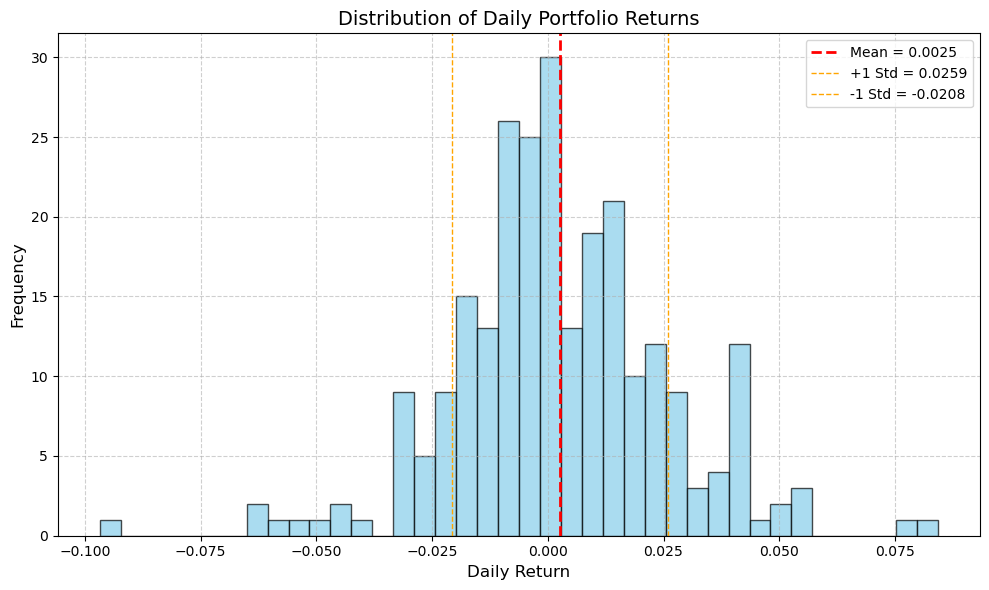

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ledger_updated["daily_return"].dropna(), bins=40, color="skyblue", edgecolor="black", alpha=0.7)

# Add mean and +-1 std lines
mean_ret = ledger_updated["daily_return"].mean()
std_ret  = ledger_updated["daily_return"].std(ddof=1)

plt.axvline(mean_ret, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_ret:.4f}")
plt.axvline(mean_ret + std_ret, color="orange", linestyle="--", linewidth=1, label=f"+1 Std = {mean_ret + std_ret:.4f}")
plt.axvline(mean_ret - std_ret, color="orange", linestyle="--", linewidth=1, label=f"-1 Std = {mean_ret - std_ret:.4f}")

# Labels and title
plt.title("Distribution of Daily Portfolio Returns", fontsize=14)
plt.xlabel("Daily Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Reflection

Working on this project helped me understand how real trading strategies are affected by much more than just price movements. 

Building the return-on-capital model step by step made it clear how financing rates, stock borrow costs, and margin rules can change the outcome of a trade. 

I also learned how daily interest accruals and variation margin requirements play a big role in managing risk and maintaining sufficient equity. 

It was interesting to see how even a market-neutral pair trade like NVDA vs AVGO can still experience gains or losses depending on funding and market conditions. 

Overall, this exercise gave me a more practical view of how leverage and margin affect performance in an actual trading environment.